In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import datetime as dt
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
C:\Users\LES\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
gold = pd.read_csv('../data/gold_price.csv',parse_dates=['Name'])
cpi = pd.read_csv('../data/cpiaucsl_with_8mths_fcast.csv',parse_dates=['DATE'])
rates = pd.read_csv('../data/fedfunds_with_8mths_fcast.csv',parse_dates=['DATE'])

In [3]:
gold.rename(columns={'Name':'Date'}, inplace=True)
gold.rename(columns={'US dollar':'spot gold'}, inplace=True)
cpi.rename(columns={'DATE':'Date'}, inplace=True)
rates.rename(columns={'DATE':'Date'}, inplace=True)

gold['Date'] = pd.to_datetime(gold['Date'])
cpi['Date'] = pd.to_datetime(cpi['Date'])
rates['Date'] = pd.to_datetime(rates['Date'])

In [4]:
gold['Date'] = gold['Date'].apply(lambda dt: dt.replace(day=1))

In [5]:
gold.set_index('Date', inplace=True)
cpi.set_index('Date', inplace=True)
rates.set_index('Date', inplace=True)

In [6]:
gold.index.freq='MS'
cpi.index.freq='MS'
rates.index.freq='MS'

In [7]:
print(rates.shape)
print(cpi.shape)

(798, 1)
(888, 1)


In [8]:
gold = gold.loc['1970-01-01':]
cpi = cpi.loc['1970-01-01':]
rates = rates.loc['1970-01-01':]

In [9]:
print(rates.shape)
print(cpi.shape)

(612, 1)
(612, 1)


In [10]:
gold.shape

(604, 1)

In [11]:
combined = pd.concat([gold, cpi, rates ], axis=1)

In [12]:
combined.shape

(612, 3)

In [13]:
combined.tail(12)

,spot gold,CPIAUCSL,FEDFUNDS
Date,,,
2020-01-01,1584.20,258.820,1.55
2020-02-01,1609.85,259.050,1.58
2020-03-01,1608.95,257.953,0.65
2020-04-01,1702.75,255.902,0.05
2020-05-01,NaN,255.830,0.05
2020-06-01,NaN,255.710,0.05
2020-07-01,NaN,255.770,0.05
2020-08-01,NaN,256.320,0.05
2020-09-01,NaN,256.040,0.05


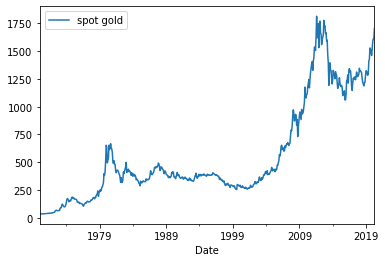

In [14]:
gold.plot()

In [15]:
def adf_test(series):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(gold['spot gold'])

ADF test statistic       -0.019293
p-value                   0.956907
# lags used              11.000000
# observations          592.000000
critical value (1%)      -3.441444
critical value (5%)      -2.866435
critical value (10%)     -2.569377
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


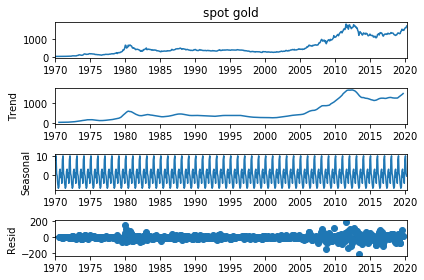

In [17]:
# Strong Seasonl component observed

decompose = seasonal_decompose(gold['spot gold'], model='add')
decompose.plot();

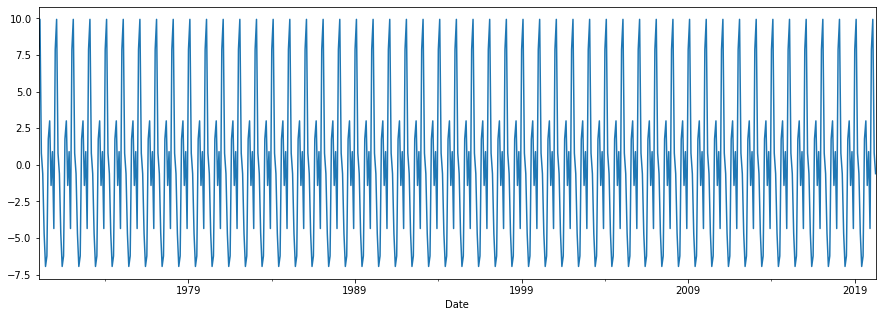

In [18]:
decompose.seasonal.plot(figsize=(15,5))

In [19]:
#month_plot(gold['spot gold'])

In [20]:
# Like GridSearchCV, auto arima helps to find the best parameters for the ARIMA model
# Notice here, it is absolutely fine to use all data as we looking for the best weights for the model
# Seasonal set to true and since this is monthly, we set m =12
aa = auto_arima(gold['spot gold'], seasonal=True,m=12)

In [21]:
# auto_arima gives basic arima: p,d,q as (2, 1, 2) and
# Seaonal component values: (0, 0, 0, 12)
aa.get_params

<bound method BaseEstimator.get_params of ARIMA(order=(2, 1, 2), seasonal_order=(0, 0, 0, 12))>

In [22]:
len(gold)   

604

In [23]:
train = gold[:592]
test = gold[592:]

In [24]:
# Basically a SARIMA model here, without the exogenous variable stated
# Uses only train data to train the model
model = SARIMAX(train['spot gold'],order=(2, 1, 2),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)

In [25]:
results = model.fit()

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              spot gold   No. Observations:                  592
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2965.269
Date:                Mon, 08 Jun 2020   AIC                           5940.538
Time:                        10:52:59   BIC                           5962.447
Sample:                    01-01-1970   HQIC                          5949.073
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3805      0.017    -79.856      0.000      -1.414      -1.347
ar.L2         -0.9503      0.021    -46.317      0.000      -0.991      -0.910
ma.L1          1.3592      0.026     52.401      0.000       1.308       1.410
ma.L2          0.8931      0.028     31.823      0.000       0.838       0.948
sigma2      1334.3880     37.247     35.826      0.000    1261.386    1407.390
===================================================================================
Ljung-Box (Q):                      109.30   Jarque-Bera (JB):              1416.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.47   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
start = len(train)
end =  len(train) + len(test) - 1

In [28]:
predictions = results.predict(start=start,end=end).rename('SARIMA Predictions')

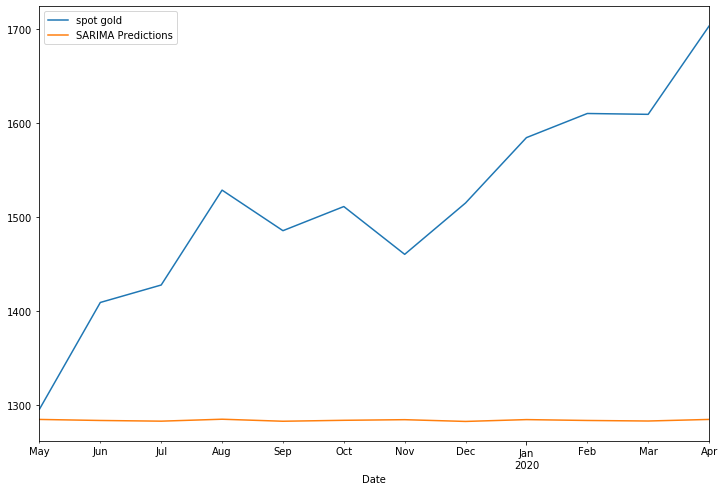

In [29]:
test['spot gold'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True)

In [30]:
#predictions = results.predict().rename('SARIMA Predictions')
#gold['spot gold']['2010':].plot(legend=True, figsize=(16,5))
#predictions['2010':].plot(legend=True)

In [31]:
error = rmse(test['spot gold'],predictions)
error

250.13918505792446

In [32]:
predictions.mean()

1283.766920369013

In [33]:
combined.shape

(612, 3)

In [34]:
gold.shape

(604, 1)

In [35]:
cpi.shape

(612, 1)

In [36]:
rates = rates.loc['1970-01-01':]

In [37]:
combined1 = combined.loc[:'2020-04-01']

In [38]:
combined1.shape

(604, 3)

In [39]:
combined1.isna().sum()

spot gold    0
CPIAUCSL     0
FEDFUNDS     0
dtype: int64

In [40]:
# Again, can use the full data while getting best params from auto_arima
aa = auto_arima(combined1['spot gold'], exogenous=combined1[['CPIAUCSL','FEDFUNDS']],seasonal=True,m=12)

In [41]:
aa.get_params

<bound method BaseEstimator.get_params of ARIMA(order=(2, 1, 2), seasonal_order=(0, 0, 0, 12))>

In [42]:
train = combined1[:596]
test = combined1[596:]

In [43]:
test.head()

,spot gold,CPIAUCSL,FEDFUNDS
Date,,,
2019-09-01,1485.30,256.593,2.04
2019-10-01,1510.95,257.229,1.83
2019-11-01,1460.15,257.824,1.55
2019-12-01,1514.75,258.444,1.55
2020-01-01,1584.20,258.820,1.55


In [44]:
sx_model = SARIMAX(train['spot gold'],exog=train[['CPIAUCSL','FEDFUNDS']],order=(2, 1, 2),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)

In [45]:
sx_result = sx_model.fit()

In [46]:
start = len(train)
end =  len(train) + len(test) - 1

In [47]:
sx_predictions = sx_result.predict(start=start,end=end, exog=test[['CPIAUCSL','FEDFUNDS']]).rename('SARIMAX Predictions')

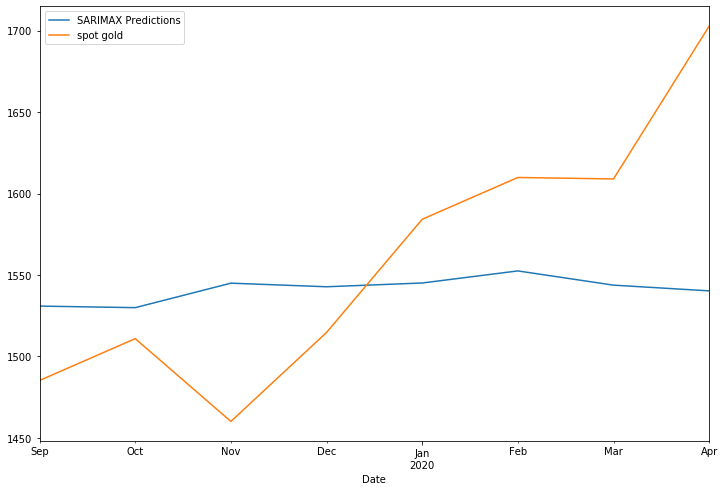

In [48]:
sx_predictions.plot(legend=True, figsize=(12,8))
test['spot gold'].plot(legend=True)

In [49]:
error = rmse(test['spot gold'],sx_predictions)
error

75.7394036869196

In [50]:
final_sx_model = SARIMAX(combined1['spot gold'],exog=combined1[['CPIAUCSL','FEDFUNDS']],order=(2, 1, 2),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)

In [51]:
final_sx_results = final_sx_model.fit()

In [52]:
exog_fcast = combined[604:][['CPIAUCSL','FEDFUNDS']]

In [53]:
final_sx_fcast = final_sx_results.predict(len(combined1),len(combined1)+7,exog=exog_fcast).rename('final sx_fcast')

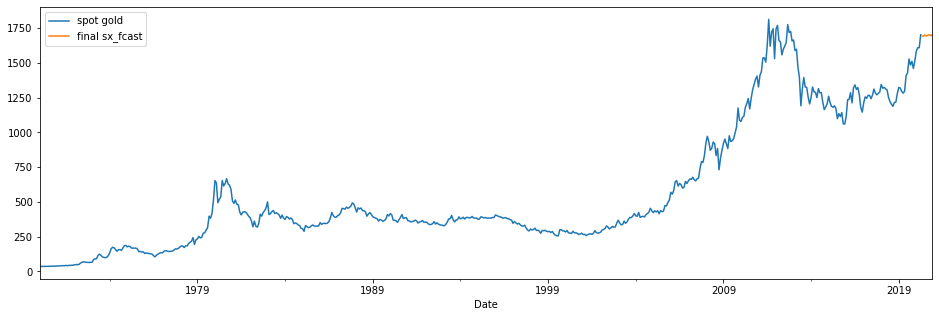

In [54]:
combined1['spot gold'].plot(legend=True, figsize=(16,5))
final_sx_fcast.plot(legend=True)

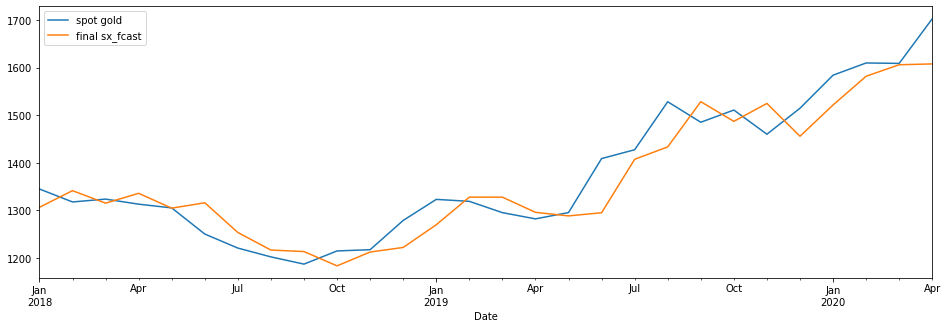

In [55]:
final_sx_fcast = final_sx_results.predict(exog=exog_fcast).rename('final sx_fcast')
combined1['spot gold']['2018':].plot(legend=True, figsize=(16,5))
final_sx_fcast['2018':].plot(legend=True)